# Connectome visualizer

### Some precomputations

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from ipywidgets import interact, IntSlider

def init():
    dfs = pd.read_csv('data/Neuro279_Syn.csv', index_col=0)
    dfg = pd.read_csv('data/Neuro279_EJ.csv', index_col=0)
    return dfs, dfg
    
dfs, dfg = init()
# dfg = dfg.sort_index(0)
# dfs = dfs.sort_index(1)
# dfg = dfg.sort_index(0)
# dfs = dfs.sort_index(1)
dfcat = pd.read_csv('data/neuron_categories.csv', index_col=1, header=0)
nbs = [i for i in range(len(dfs.index))]
cats = dfcat.loc[dfg.index]
motors = cats.index[cats['Category']=='MOTOR']
inters = cats.index[cats['Category']=='INTERNEURON']
sensors = cats.index[cats['Category']=='SENSORY']

### Visualization

In [2]:
""" Preferences : you can change the shape and colors of neuron categories here """
SENSOR_COLOR = '#006000'
SENSOR_SHAPE = 'o'
INTER_COLOR = '#000060'
INTER_SHAPE = 'o'
MOTOR_COLOR = '#600000'
MOTOR_SHAPE = 'o'
NODE_SIZE = 2500

style = ArrowStyle("wedge", tail_width=2., shrink_factor=0.2)
styleg = ArrowStyle("wedge", tail_width=0.6, shrink_factor=0.4)
CONN_STYLE = 'arc3, rad=0.3'

In [6]:
@interact(neuron = sorted(dfs.index), img_size=IntSlider(min=10,max=22,step=2,value=12), connstyle=[CONN_STYLE, None])
def connections(neuron='DB07', img_size=12, connstyle=None):
    fig = plt.figure(figsize=(img_size,img_size))
    G = nx.DiGraph()
    
    syn_in = dfs.index[dfs[neuron] > 0].tolist()
    intens_in = dfs.loc[dfs[neuron] > 0, neuron]
    syni = [(pre, neuron, {}) for pre in syn_in]
    G.add_edges_from(syni)
    
    gaps_ = dfg.index[dfg[neuron] > 0].tolist()
    intens_g = 0.1*dfg.loc[dfg[neuron] > 0, neuron]
    gapso = [(neuron, k, {}) for k in gaps_] 
    gapsi = [(k, neuron, {}) for k in gaps_]
    gaps = gapsi + gapso
    G.add_edges_from(gaps)
    
    syn_out = dfs.T.index[dfs.T[neuron] > 0].tolist()
    intens_out = dfs.T.loc[dfs.T[neuron] > 0, neuron]
    syno = [(neuron, post, {}) for post in syn_out]
    G.add_edges_from(syno)
    
    G.remove_node(neuron)
    pos = nx.layout.circular_layout(G)
    G.add_node(neuron)
    pos[neuron] = np.array([0,0])

#     pos = {}
#     inputs = np.unique([ni for (ni,__,__) in syni + gapsi])
#     for i, ni in enumerate(inputs):
#         pos[ni] = [-1, i / (len(inputs)-1)]
#     for i, (__,ni,__) in enumerate(syno):
#         pos[ni] = [1, i / len(syno)]
#     pos[neuron] = [0,0.5]
#     pos['VD13'] = [1,0.5]
    
    def draw_nodes(shape='o', category=inters, col='k'):
        nx.draw_networkx_nodes(G, pos, node_shape=shape, node_color=col, 
                               nodelist=[n for n in G.nodes if n in category],
                               node_size=NODE_SIZE, alpha=0.9)
    draw_nodes(SENSOR_SHAPE, sensors, SENSOR_COLOR)
    draw_nodes(INTER_SHAPE, inters, INTER_COLOR)
    draw_nodes(MOTOR_SHAPE, motors, MOTOR_COLOR)

    nx.draw_networkx_labels(G, pos, font_color='w', font_weight='bold')
    
    nx.draw_networkx_edges(G, pos, arrowstyle=style, edgelist=syni, edge_color='g', connectionstyle=connstyle,
                           arrowsize=10, alpha=0.7, width=intens_in, node_size=NODE_SIZE)
    nx.draw_networkx_edges(G, pos, arrowstyle=style, edgelist=syno, edge_color='r', connectionstyle=connstyle,
                           arrowsize=10, alpha=0.5, width=intens_out, node_size=NODE_SIZE)
    nx.draw_networkx_edges(G, pos, arrowstyle=styleg, edgelist=gaps, edge_color='Gold',
                           arrowsize=10, alpha=0.8, width=np.hstack((intens_g,intens_g)), 
                           node_size=NODE_SIZE)
    
    plt.axis('off')
    plt.show()

interactive(children=(Dropdown(description='neuron', index=101, options=('ADAL', 'ADAR', 'ADEL', 'ADER', 'ADFL…

## Plot the whole network

In [7]:
A = 'SMDDL'
B = 'SMDVL'

def select_adj(dfs, dfg):
    adjs = [A, B]
    adjs.extend(dfs.index[dfs[A] > 0])
#     adjs.extend(dfs.index[dfs.loc[A] > 0])
    adjs.extend(dfg.index[dfs[A] > 0])
#     adjs.extend(dfg.index[dfs.loc[A] > 0])
    adjs.extend(dfs.index[dfs[B] > 0])
#     adjs.extend(dfs.index[dfs.loc[B] > 0])
    adjs.extend(dfg.index[dfs[B] > 0])
#     adjs.extend(dfg.index[dfs.loc[B] > 0])
    adjs = list(set(adjs))

    dfg2 = dfg.loc[adjs, adjs]
    dfs2 = dfs.loc[adjs, adjs]
    return dfs2, dfg2

In [8]:
dfs, dfg = init()

# dfs, dfg = select_adj(dfs, dfg)
# select = ['AIBL', 'AIBR', 'ALA', 'ALNL', 'ALNR']
# dfg = dfg.loc[select, select]
# dfs = dfs.loc[select, select]

labels = {i:dfg.index[i] for i in range(dfg.shape[0])}
G1 = nx.from_numpy_matrix(dfs.values)#, create_using=nx.DiGraph())
G1 = nx.relabel.relabel_nodes(G1, labels)
G2 = nx.from_numpy_matrix(dfg.values)#, create_using=nx.DiGraph())
G2 = nx.relabel.relabel_nodes(G2, labels)

G = nx.Graph()
G.add_edges_from(G1.edges)
G.add_edges_from(G2.edges)

rich = ['AVAL', 'AVAR', 'AVBL', 'AVBR', 'AVDL', 'AVDR', 'AVEL', 'AVER', 'PVCL', 'PVCR', 'DVA']
rich2 = ['RIBL']
rich3 = ['AIBR', 'RIAR']
labs = ['AIBL', 'AIBR', 'ALA', 'ALNL', 'ALNR', 'AS10', 'ASKL', 'ASKR', 'AVAL',
       'AVAR', 'AVBL', 'AVBR', 'AVEL', 'AVER', 'AVFL', 'AVFR', 'BAGL', 'DA01',
       'DA07', 'DA09', 'DB01', 'DB02', 'DB07', 'DVA', 'DVC', 'LUAR', 'OLQDL',
       'OLQDR', 'OLQVL', 'OLQVR', 'PDA', 'PHAR', 'PVCL', 'PVCR', 'PVNL',
       'PVNR', 'RIBL', 'RIBR', 'RID', 'RIFR', 'RIMR', 'RIS', 'RIVR', 'RMED',
       'RMEL', 'RMEV', 'SABD', 'SABVL', 'SABVR', 'SIADL', 'SIADR', 'SIAVL',
       'SIAVR', 'SMDDL', 'SMDDR', 'SMDVL', 'SMDVR', 'VA01', 'VA11', 'VA12',
       'VB02', 'VB11', 'VD11', 'VD13']

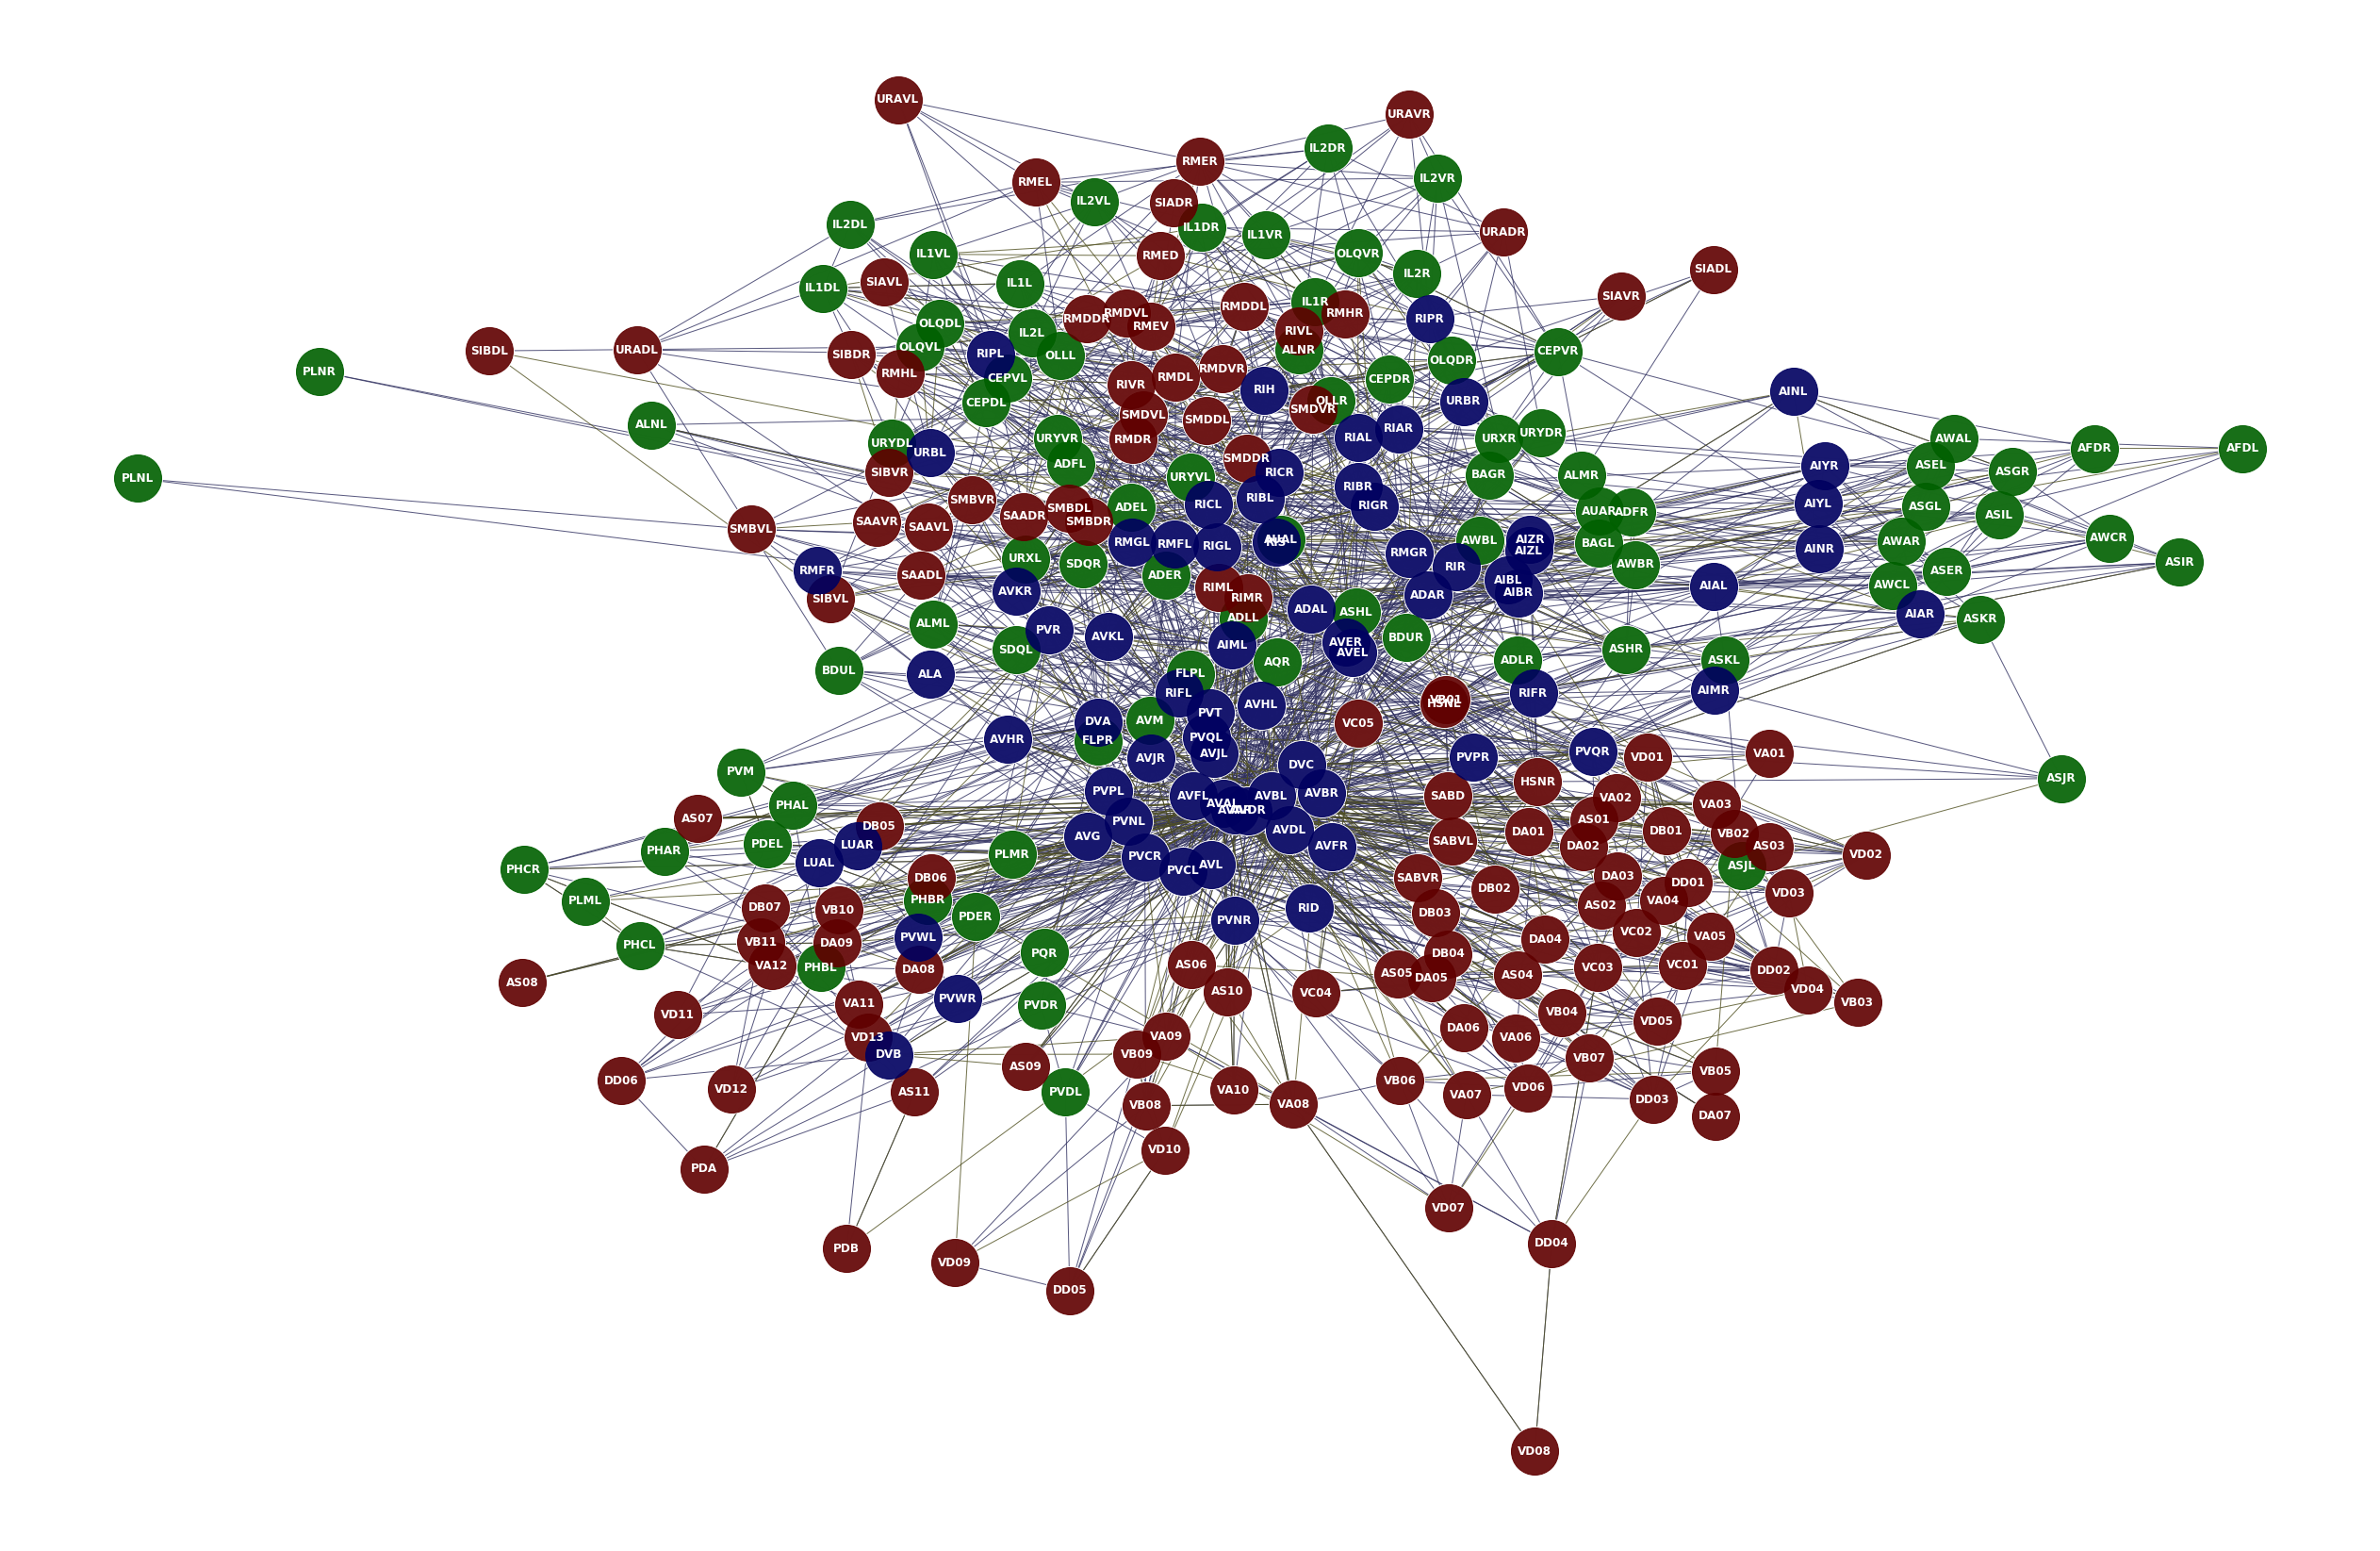

In [9]:
def draw_nodes(pos, shape='o', category=inters, col='k', size=NODE_SIZE, G=G):
            nx.draw_networkx_nodes(G, pos, node_shape=shape, node_color=col, 
                                   nodelist=[n for n in G.nodes if n in category],
                                   node_size=size, alpha=0.9)
        
def draw_rich(pos, neurs=rich, sk=7000, sr=6500, sg=5000, G=G):
        draw_nodes(pos, 'o', neurs, 'white', sk, G)
        draw_nodes(pos, 'o', neurs, 'r', sr, G)
        draw_nodes(pos, 'o', neurs, 'Gold', sg, G)
        draw_nodes(pos, INTER_SHAPE, neurs, INTER_COLOR, NODE_SIZE, G)

def whole(img_size=30, pos=None):
    plt.figure(figsize=(1.5*img_size, img_size))  
    dpi = 2000/img_size
    
#     ['AIBL', 'AIBR', 'RIAL', 'RIAR', 'RIBL', 'RIBR']
    # pos = nx.layout.bipartite_layout(G, sensors)
    if pos is None:
        pos = nx.layout.spring_layout(G)
            
    draw_nodes(pos, 'o', G.nodes, 'white', size=2700)
    draw_nodes(pos, SENSOR_SHAPE, sensors, SENSOR_COLOR)
    draw_nodes(pos, MOTOR_SHAPE, motors, MOTOR_COLOR)
    draw_nodes(pos, INTER_SHAPE, inters, INTER_COLOR)

    nx.draw_networkx_edges(G, pos, edge_color='#303060', node_size=NODE_SIZE, arrowstyle='->', edgelist=G1.edges, 
                           alpha=0., width=1, arrowsize=10)
    nx.draw_networkx_edges(G, pos, edge_color='#505020', node_size=NODE_SIZE, arrowstyle='->', edgelist=G2.edges, 
                           alpha=0.8, width=1)

    nx.draw_networkx_labels(G, pos, font_color='w', font_weight='bold')

    plt.axis('off')
    
#     plt.draw()
#     plt.savefig('circ%s.png'%img_size, dpi=dpi)

#     draw_rich(pos, rich3, sk=4600, sr=4500, sg=4500)
#     draw_rich(pos, rich2, sk=5600, sr=5500, sg=4500)
#     draw_rich(pos, rich)

#     draw_nodes(pos, '*', labs, 'k', size=7500)
#     draw_nodes(pos, '*', labs, 'w', size=7000)
#     draw_nodes(pos, '*', labs, 'Gold', size=6000)
#     nx.draw_networkx_labels(G, pos, labels={l:l for l in labs}, font_color='k', font_weight='bold')
    
    plt.draw()
    plt.savefig('circ%s_rich.png'%img_size, dpi=dpi)
    return pos
    
    
a = whole(30)
# poss = []
# for i in [25,34]:
#     whole(i, poss[0])



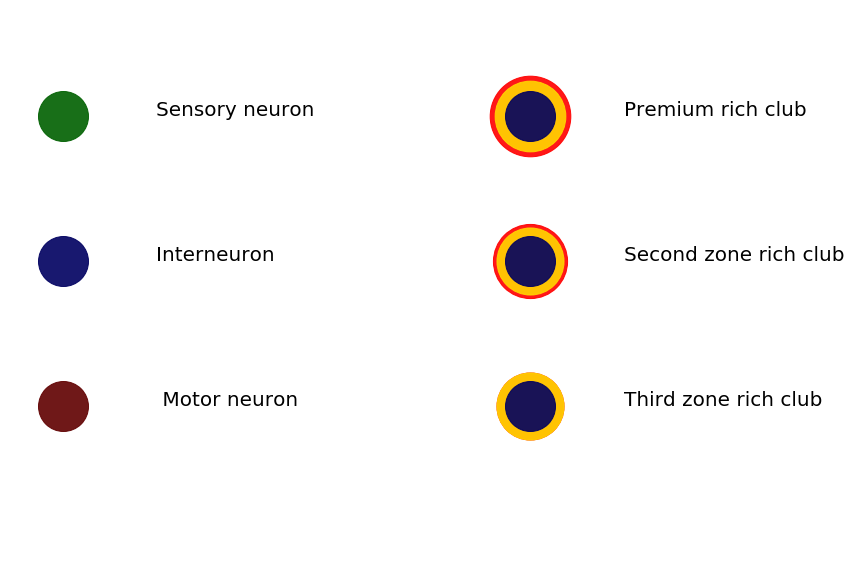

In [206]:
"""Create legend"""

plt.figure(figsize=(10,10))
g = nx.Graph()
nodes = range(6)
g.add_nodes_from(nodes)
legends = ['Sensory neuron', 'Interneuron', ' Motor neuron', 
           'Premium rich club', 'Second zone rich club', 'Third zone rich club']
pos = {}
for i in nodes:
    pos[i] = [10*(i//3),-20*(i%3)]
    plt.text(pos[i][0]+2, pos[i][1], legends[i], fontsize=20)
draw_nodes(pos, SENSOR_SHAPE, [0], SENSOR_COLOR, G=g)
draw_nodes(pos, INTER_SHAPE, [1], INTER_COLOR, G=g)
draw_nodes(pos, MOTOR_SHAPE, [2], MOTOR_COLOR, G=g)
draw_rich(pos, [3], G=g)
draw_rich(pos, [4], sk=5600, sr=5500, sg=4500, G=g)
draw_rich(pos, [5], sk=4600, sr=4500, sg=4500, G=g)
plt.ylim(-60, 15)
# plt.xlim(0, 15)
plt.axis('off')
plt.draw()
plt.savefig('legend.png',dpi=200)

In [108]:
import pickle

with open('Manuel/pos', 'wb') as f:
    pickle.dump(poss[0], f)